In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import netCDF4 as nc
%matplotlib inline
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'Dejavu Serif'

In [3]:
# constants
secondsPerDay = 86400
nx = 500
ny = 500

# plotting params
deepIndex = 35
yRange = np.linspace(-ny,ny,ny)
yRMeters = yRange*1000

# io params
loc = f"/scratch/hcm7920/ambData/levelMean/"
conc = ["0", "20", "40", "60", "80", "100"]
saveloc = "/home/hcm7920/experiments/arcticMiddepthBI/plots/"

In [4]:
# load data

levs = np.load(loc+"../grid/gridLevs.npy")

timeDiags = np.load(loc+"../grid/gridTimeDiags.npy")
keLevMax = np.load(loc+"levelMaxKE.npy")
keLevMean = np.load(loc+"levelMeanKE.npy")

channelMeanU  = np.load(loc+"../channelMean/channelMeanU.npy")
channelMeanV  = np.load(loc+"../channelMean/channelMeanV.npy")
channelMeanKE = np.load(loc+"../channelMean/channelMeanKE.npy")

uvPrimeSquareChannelCenter = np.zeros(shape=(148,50,500,6))


In [5]:
# calculate EKE and MKE
# average after squaring for grid colocation

mKE = 0.5*(
  channelMeanU**2
  + 0.5*channelMeanV[:,1:,:]**2
  + 0.5*channelMeanV[:,:-1,:]**2)
eKE = channelMeanKE - mKE


In [6]:
# calculate u', v' at channel center
# average in u after squaring (for grid colocation)

for ic in range(len(conc)):
  myData = nc.Dataset(f"/scratch/hcm7920/amb{conc[ic]}/data/state.nc")
  uvPrimeSquareChannelCenter[:,:,:,ic] += 0.25*(
    (myData['U'][:,:,250,:-1]-channelMeanU[None,:,250,None,ic])**2)
  uvPrimeSquareChannelCenter[:,:,:,ic] += 0.25*(
    (myData['U'][:,:,250,1:]-channelMeanU[None,:,250,None,ic])**2)
  uvPrimeSquareChannelCenter[:,:,:,ic] += 0.5*(
    (myData['V'][:,:,250,:]-channelMeanV[None,:,250,None,ic])**2)


In [7]:
# make example plots

# fig,ax = plt.subplots(len(conc),1,sharex=True,
#                      figsize=(10,12),
#                      layout='constrained')
# for ic in range(len(conc)):

#   myMax = channelMeanKE[:,:,ic].max()*1000
#   contourLevels = np.linspace(0,myMax,50)
#   im = ax[ic].contourf(yRange, levs[:deepIndex],
#                       channelMeanKE[:deepIndex,:,ic]*1000,
#                       contourLevels, cmap='magma')
#   cbar = plt.colorbar(im, ax=ax[ic])
#   cbar.ax.set_title("$10^{-3}$")
#   ax[0].set_ylabel("Depth (m)")


# ax[0].set_title("Ice free $\overline{\mathrm{KE}}$")
# ax[1].set_title("Max ice KE")
# ax[1].set_xlabel("Across channel distance (km)")



In [8]:
# make example plots

# fig,ax = plt.subplots(1,len(conc),sharey=True,
#                      figsize=(12,4),
#                      layout='constrained')

# for ic in range(len(conc)):
  
#   myMax = mKE[:,:,ic].max()
#   contourLevels = np.linspace(0,myMax,50)
#   im = ax[ic].contourf(yRange, levs[:deepIndex],
#                       mKE[:deepIndex,:,ic],
#                       contourLevels, cmap='magma')
#   ax[ic].set_xlabel("Across channel distance (km)")
#   ax[ic].set_ylabel("Depth (m)")
#   ax[ic].set_title(f"{conc[ic]}%, mKE")



In [9]:
# make example plots

# fig,ax = plt.subplots(1,len(conc),sharey=True,
#                      figsize=(12,4),
#                      layout='constrained')

# for ic in range(len(conc)):
  
#   myMax = eKE[:,:,ic].max()
#   contourLevels = np.linspace(0,myMax,50)
#   im = ax[ic].contourf(yRange, levs[:deepIndex],
#                       eKE[:deepIndex,:,ic],
#                       contourLevels, cmap='magma')
#   ax[ic].set_xlabel("Across channel distance (km)")
#   ax[ic].set_ylabel("Depth (m)")
#   ax[ic].set_title(f"{conc[ic]}%, eKE")



Text(0.5, 1.0, 'Ice covered')

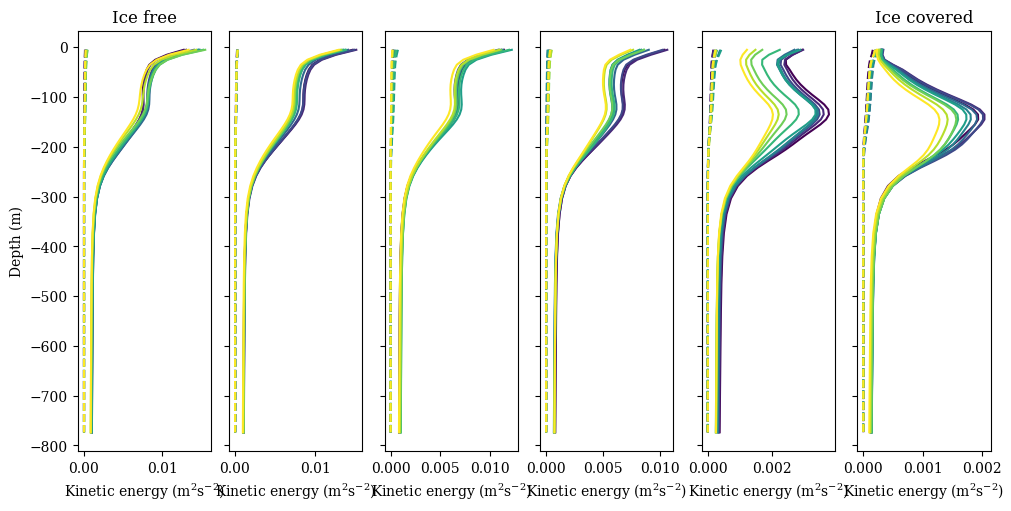

In [10]:
# profiles of KE, EKE, and MKE, testing for location

deepIndex = 35
pLocs = np.arange(210,310,10)
colors = plt.cm.viridis(np.linspace(0,1,10))
fig, ax = plt.subplots(1,len(conc),sharey=True,
                      layout='constrained',
                      figsize=(10,5))

for ic in range(len(conc)):
  for ip in range(10):
    ax[ic].plot(eKE[:deepIndex,pLocs[ip],ic],
               levs[:deepIndex],
               color=colors[ip],
               linestyle='solid',
               label=f'Eddy KE {ip+1}')
    ax[ic].plot(mKE[:deepIndex,pLocs[ip],ic],
               levs[:deepIndex],
               color=colors[ip],
               linestyle='dashed',
               label=f'Mean KE {ip+1}')
  lbl1 = "Kinetic energy ($\mathrm{m}^2\mathrm{s}^{-2}$)"
  ax[ic].set_xlabel(lbl1)

ax[0].set_ylabel("Depth (m)")
ax[0].set_title("Ice free")
ax[-1].set_title("Ice covered")


In [11]:
# more x and time axis in prep for np.reshape; (time,z,x,ic)->(ic,z,time,x)
data = np.moveaxis(uvPrimeSquareChannelCenter,[0,1,2,3],[2,1,3,0])
print(data.shape)
data = data.reshape((6,50,148*500))
rootData = np.sqrt(data)

(6, 50, 148, 500)


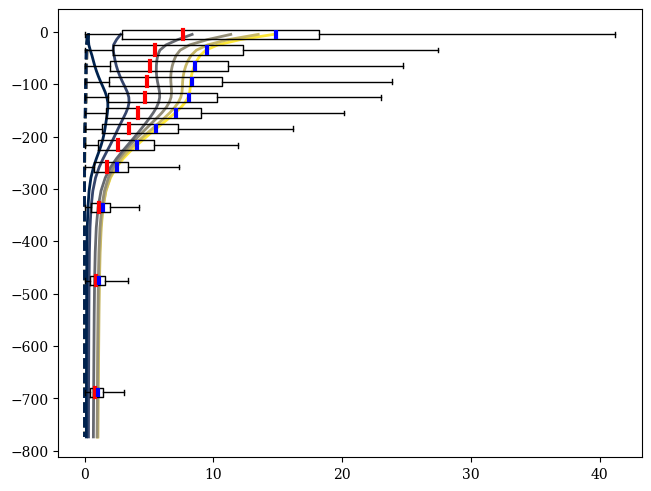

In [12]:
# profiles of mKE & eKE, with box and whisker

deepIndex = 35
colors = plt.cm.cividis_r(np.linspace(0,1,len(conc)))
lbl = ["0%", "20%", "40%", "60%", "80%", "100%"]
plt.figure(layout="constrained")

for ic in range(len(conc)):

  # line plot
  plt.plot((eKE[:deepIndex,250:252,ic].mean((1,))*1e3),
          levs[:deepIndex],
          color=colors[ic],
          linestyle='solid',
          linewidth=2)
  plt.plot((mKE[:deepIndex,187:-187,ic].mean((1,))*1e3),
          levs[:deepIndex],
          color=colors[ic],
          linestyle='dashed',
          linewidth=2)

for ic in range(1):
  # box and whisker for eKE
  propDict1 = {'linewidth':3,'color':'blue'}
  propDict2 = {'linewidth':3,'color':'red'}
  currentAx = plt.gca()
  currentAx.boxplot(data[ic,:deepIndex:3,:].T*1e3,
             notch=False,
             sym='',
             vert=False,
             positions=levs[:deepIndex:3],
             manage_ticks=False,
             widths=18,
             meanline=True,
             showmeans=True,
             meanprops=propDict1,
             medianprops=propDict2);

# unitLbl = "($\mathrm{m}^2\,\mathrm{s}^{-2}\,10^{-3}$)"
# plt.xlabel("Kinetic energy "+unitLbl)
# plt.ylabel("Depth (m)")
# legend_elements = []
# for ic in range(len(conc)):
#   holder = Line2D([0], [0], color=colors[ic], label=f"{lbl[ic]} SIC")
#   legend_elements.append(holder)
# legend_elements.append(Line2D([0],[0],color="white",label=""))
# legend_elements.append(Line2D([0],[0],color="gray",label="Eddy KE"))
# legend_elements.append(Line2D([0],[0],color="gray",
#                               linestyle="dashed",label="Mean KE"))
# plt.legend(handles=legend_elements)

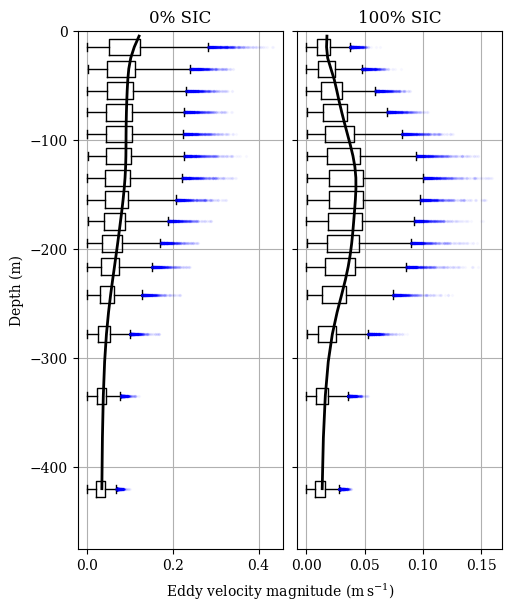

In [13]:
deepIndex = 30
colors = plt.cm.cividis_r(np.linspace(0,1,len(conc)))
lbl = ["0%", "20%", "40%", "60%", "80%", "100%"]
fig,ax = plt.subplots(1,2,layout="constrained",
                      figsize=(5,6),sharey=True)
desiredConc = [0,5]

for ic in range(2):
  # ax[ic].set_xlabel("Kinetic energy "+unitLbl)
  ax[ic].set_title(lbl[desiredConc[ic]]+" SIC")
  ax[ic].grid(visible=True)
  ax[ic].set_ylim([levs[deepIndex],0])

  ax[ic].plot((np.sqrt(eKE[:deepIndex,250:252,desiredConc[ic]].mean((1,)))),
          levs[:deepIndex],
          color='black',
          linestyle='solid',
          linewidth=2)

  # box and whisker for eKE
  propDict1 = {'linewidth':3,'color':'black'}
  propDict2 = {'linewidth':0,'color':'grey'}
  propDict3 = {'markersize':3,'alpha':0.02}
  ax[ic].boxplot(rootData[desiredConc[ic],1:deepIndex:2,:].T,
             notch=False,
             sym='b.',
             vert=False,
             positions=levs[1:deepIndex:2],
             manage_ticks=False,
             widths=15,
             meanline=True,
             showmeans=False,
             meanprops=propDict1,
             medianprops=propDict2,
             flierprops=propDict3,
             showfliers=True,
             whis=(0,99));

unitLbl = "($\mathrm{m}^2\,\mathrm{s}^{-2}\,10^{-3}$)"
unitLbl2 = "($\mathrm{m}\,\mathrm{s}^{-1}$)"
ax[0].set_ylabel("Depth (m)")
fig.supxlabel("\t   Eddy velocity magnitude "+unitLbl2,fontsize=10)
plt.savefig(saveloc+"officialFigs/figEddyKEBoxWhisker.pdf",bbox_inches="tight")

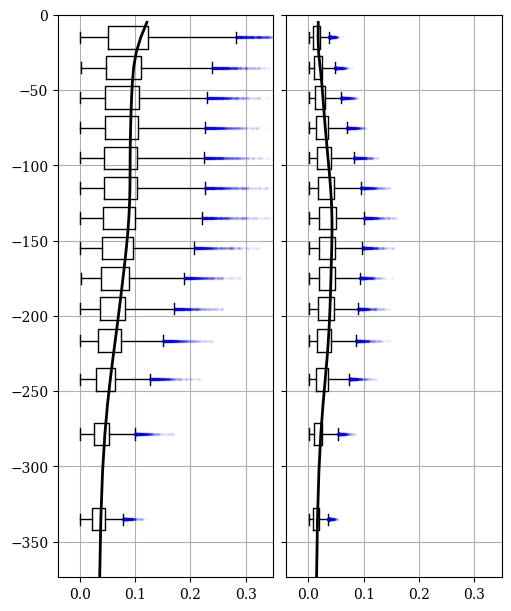

In [25]:
deepIndex = 29
colors = plt.cm.cividis_r(np.linspace(0,1,len(conc)))
lbl = ["0%", "20%", "40%", "60%", "80%", "100%"]
fig,ax = plt.subplots(1,2,layout="constrained",
                      figsize=(5,6),sharey=True)
desiredConc = [0,5]

for ic in range(2):
  # ax[ic].set_xlabel("Kinetic energy "+unitLbl)
  # ax[ic].set_title(lbl[desiredConc[ic]]+" SIC")
  ax[ic].grid(visible=True)
  ax[ic].set_ylim([levs[deepIndex-1],0])
  ax[ic].set_xlim([-0.04,0.35])

  ax[ic].plot((np.sqrt(eKE[:deepIndex,250:252,desiredConc[ic]].mean((1,)))),
          levs[:deepIndex],
          color='black',
          linestyle='solid',
          linewidth=2)

  # box and whisker for eKE
  propDict1 = {'linewidth':3,'color':'black'}
  propDict2 = {'linewidth':0,'color':'grey'}
  propDict3 = {'markersize':3,'alpha':0.02}
  ax[ic].boxplot(rootData[desiredConc[ic],1:deepIndex:2,:].T,
             notch=False,
             sym='b.',
             vert=False,
             positions=levs[1:deepIndex:2],
             manage_ticks=False,
             widths=15,
             meanline=True,
             showmeans=False,
             meanprops=propDict1,
             medianprops=propDict2,
             flierprops=propDict3,
             showfliers=True,
             whis=(0,99));

unitLbl = "($\mathrm{m}^2\,\mathrm{s}^{-2}\,10^{-3}$)"
unitLbl2 = "($\mathrm{m}\,\mathrm{s}^{-1}$)"
# ax[0].set_ylabel("Depth (m)")
# fig.supxlabel("\t   Eddy velocity magnitude "+unitLbl2,fontsize=10)
plt.savefig(saveloc+"officialFigs/figKeBoxWhisAGU24.pdf",bbox_inches="tight")

Text(0.5, 0, 'Kinetic energy ($\\mathrm{m}^2\\,\\mathrm{s}^{-2}\\,10^{-3}$)')

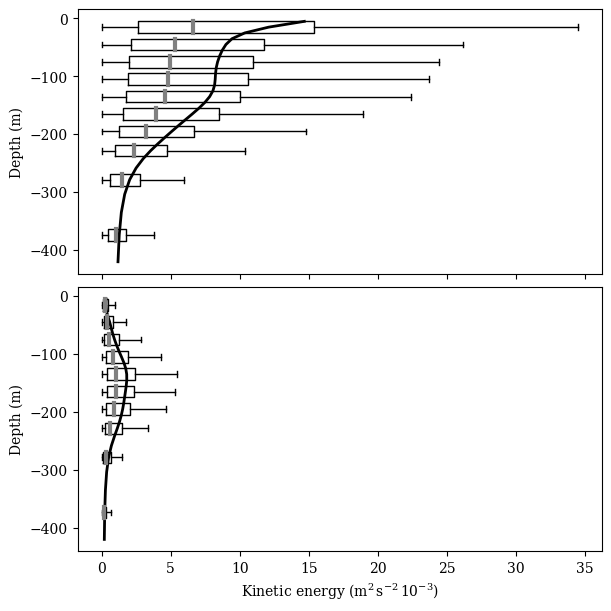

In [15]:
deepIndex = 30
colors = plt.cm.cividis_r(np.linspace(0,1,len(conc)))
lbl = ["0%", "20%", "40%", "60%", "80%", "100%"]
fig,ax = plt.subplots(2,1,layout="constrained",
                      figsize=(6,6),sharey=True,sharex=True)
desiredConc = [0,5]

for ic in range(2):
  ax[ic].set_ylabel("Depth (m)")

  ax[ic].plot((eKE[:deepIndex,250:252,desiredConc[ic]].mean((1,))*1e3),
          levs[:deepIndex],
          color='black',
          linestyle='solid',
          linewidth=2)

  # box and whisker for eKE
  propDict1 = {'linewidth':3,'color':'black'}
  propDict2 = {'linewidth':3,'color':'grey'}
  ax[ic].boxplot(data[desiredConc[ic],1:deepIndex:3,:].T*1e3,
             notch=False,
             sym='',
             vert=False,
             positions=levs[1:deepIndex:3],
             manage_ticks=False,
             widths=20,
             meanline=True,
             showmeans=False,
             meanprops=propDict1,
             medianprops=propDict2);

unitLbl = "($\mathrm{m}^2\,\mathrm{s}^{-2}\,10^{-3}$)"
ax[-1].set_xlabel("Kinetic energy "+unitLbl)


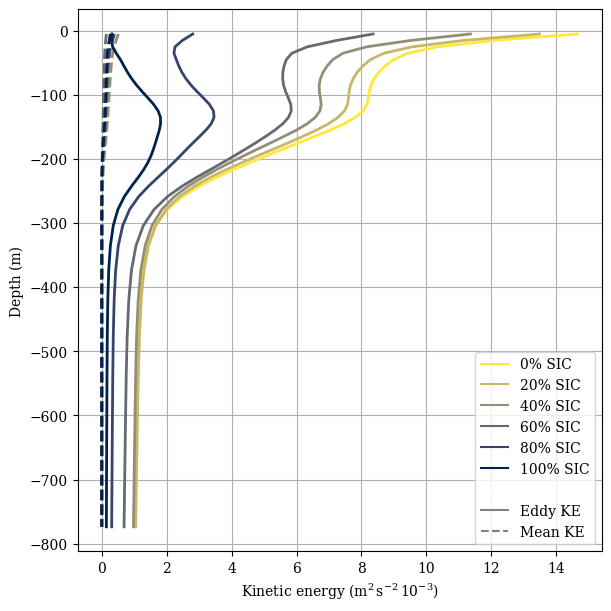

In [16]:
# profiles of mKE & eKE, official

deepIndex = 35
colors = plt.cm.cividis_r(np.linspace(0,1,len(conc)))
lbl = ["0%", "20%", "40%", "60%", "80%", "100%"]
plt.figure(layout="constrained",figsize=(6,6))
ax = plt.gca()
ax.grid(visible=True)
# ax.set_ylim([levs[deepIndex],0])

for ic in range(len(conc)):

  # line plot
  plt.plot((eKE[:deepIndex,250:252,ic].mean((1,))*1e3),
          levs[:deepIndex],
          color=colors[ic],
          linestyle='solid',
          linewidth=2)
  plt.plot((mKE[:deepIndex,250:252,ic].mean((1,))*1e3),
          levs[:deepIndex],
          color=colors[ic],
          linestyle='dashed',
          linewidth=2)

unitLbl = "($\mathrm{m}^2\,\mathrm{s}^{-2}\,10^{-3}$)"
plt.xlabel("Kinetic energy "+unitLbl)
plt.ylabel("Depth (m)")
legend_elements = []
for ic in range(len(conc)):
  holder = Line2D([0], [0], color=colors[ic], label=f"{lbl[ic]} SIC")
  legend_elements.append(holder)
legend_elements.append(Line2D([0],[0],color="white",label=""))
legend_elements.append(Line2D([0],[0],color="gray",label="Eddy KE"))
legend_elements.append(Line2D([0],[0],color="gray",
                              linestyle="dashed",label="Mean KE"))
plt.legend(handles=legend_elements)

plt.savefig(saveloc+"officialFigs/figEddyKEProfile.pdf",bbox_inches="tight")

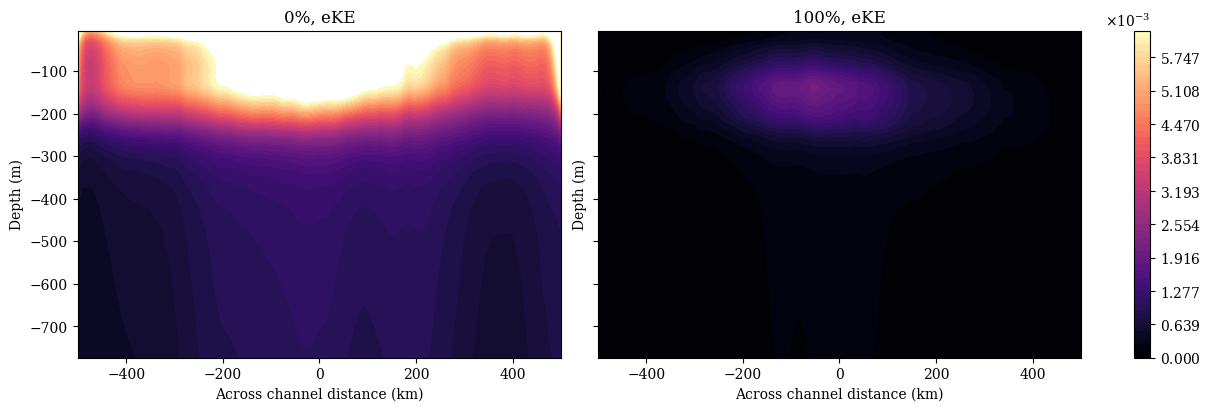

In [17]:

fig,ax = plt.subplots(1,2,sharey=True,
                     figsize=(12,4),
                     layout='constrained')

myMax = eKE[:,:,0].max() * 0.4
contourLevels = np.linspace(0,myMax,50)
im1 = ax[0].contourf(yRange, levs[:deepIndex],
                    eKE[:deepIndex,:,0],
                    contourLevels, cmap='magma')
ax[0].set_xlabel("Across channel distance (km)")
ax[0].set_ylabel("Depth (m)")
ax[0].set_title(f"{conc[0]}%, eKE")

im2 = ax[1].contourf(yRange, levs[:deepIndex],
                    eKE[:deepIndex,:,-1],
                    contourLevels, cmap='magma')
ax[1].set_xlabel("Across channel distance (km)")
ax[1].set_ylabel("Depth (m)")
ax[1].set_title(f"{conc[-1]}%, eKE")
cbar = plt.colorbar(im1, ax=ax[1])
cbar.formatter.set_powerlimits((-3,-3))
cbar.formatter.set_useMathText(True)

